# Stance Detection with Data Augmentation
In this notebook, data augmentation is applied to stance detection.

In [1]:
import torch
import pickle

In [2]:
from datasets import SemEval, SemEvalSeenUnlabelled, StanceDataset, FactmataDataset
from torch import nn, optim
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
import numpy as np
from math import ceil
from utils import get_batch, plot_confusion_matrix
from warnings import filterwarnings

In [3]:
filterwarnings("ignore")

In [4]:
torch.cuda.set_device(1)

## Utilities and Model Implementation

In [5]:
def tokenise(text):
    return text.split()

In [6]:
def join(tokens):
    return " ".join(tokens)

In [7]:
def swap(text, p):
    tokens = tokenise(text)
    for i, token in enumerate(tokens):
        if np.random.rand() < p:
            j = np.random.randint(len(tokens))
            tokens[i], tokens[j] = tokens[j], tokens[i]
    return join(tokens)

In [8]:
def delete(text, p):
    tokens = []
    for token in tokenise(text):
        if np.random.rand() > p or (token.startswith("#") or token.startswith("@")):
            tokens.append(token)
    return join(tokens)

In [9]:
def _modify(text, swap_p, delete_p):
    return swap(delete(text, delete_p), swap_p)

In [10]:
def modify(texts, swap_p, delete_p):
    return [_modify(text, swap_p, delete_p) for text in texts]

In [11]:
def augment(texts, targets, stances, n, swap_p, delete_p):
    new = []
    for _ in range(n):
        for text, target, stance in zip(texts, targets, stances):
            new.append((_modify(text, swap_p, delete_p), target, stance))
    return StanceDataset([z[0] for z in new], [z[1] for z in new], [z[2] for z in new])

In [12]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Linear(64, 3), nn.Softmax(dim=1))
        self.cross_entropy_loss_function = nn.CrossEntropyLoss()
        
    def forward(self, inputs, labels):
        probabilities = self.classifier(inputs)
        cross_entropy = self.cross_entropy_loss_function(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), cross_entropy

In [13]:
def get_model(state_dict=None):
    torch.manual_seed(42)
    model = Model().cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Training

In [14]:
training, testing = SemEval.get_subtask_b_datasets("data/semeval/")

In [15]:
augmented = augment(training.texts, training.targets, training.stances, 10, 0.1, 0.2)

In [16]:
training = training + augmented

In [17]:
maximum_length = 77

In [18]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=maximum_length, verbose=True).cuda(), torch.tensor(training.stances).cuda()
testing_inputs = encode(testing.texts, testing.targets, method="conditional-target", maximum_length=maximum_length).cuda(), torch.tensor(testing.stances).cuda()

0 of 229
50 of 229
100 of 229
150 of 229
200 of 229


In [19]:
batch_size = 48
batches = ceil(len(training) / batch_size)
batches

955

In [26]:
model = get_model()

In [27]:
optimiser = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
step = 0

In [29]:
optimal_score, optimal_model_state_dict = 0.0, None

In [30]:
results = {
    "training": {
        "cross_entropy": []
    },
    "testing": {
        "cross_entropy": []
    },
}

In [ ]:
while True:
    
    optimiser.zero_grad()
    model.zero_grad()
    
    batch = get_batch(step, batch_size, training_inputs)
    
    _, _, loss = model(*batch)
    loss.backward()
    optimiser.step()
    
    results["training"]["cross_entropy"].append(float(loss))
    
    _, predictions, loss = model(*testing_inputs)
    
    results["testing"]["cross_entropy"].append(float(loss))
    
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    score = np.mean(scores)
    
    if score > optimal_score:
        optimal_score = score
        optimal_model_state_dict = deepcopy(model.state_dict())
        print("{}\t{}\t{}\t{}".format(step, *scores, score))

    step += 1

49454	0.32505192665807187	0.40000734008519573	0.3625296333716338
50409	0.32578893607870546	0.4000059792796186	0.36289745767916204
51364	0.32773319065453893	0.4011070555958753	0.3644201231252071


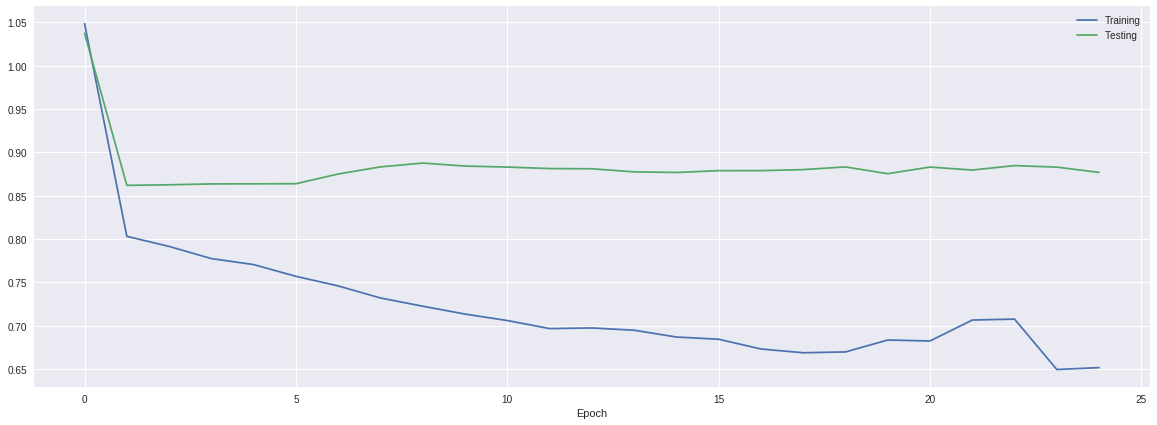

In [180]:
plt.figure(figsize=(20, 7))
plt.style.use("seaborn")

plt.plot(results["training"]["cross_entropy"][::batches])
plt.plot(results["testing"]["cross_entropy"][::batches])
plt.xlabel("Epoch")
plt.legend(["Training", "Testing"])

## Evaluation

In [240]:
model = get_model(optimal_model_state_dict)

In [241]:
_, predictions, _ = model(*testing_inputs)

In [242]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        50
           1       0.76      0.70      0.73       105
           2       0.66      0.77      0.71        83

    accuracy                           0.71       238
   macro avg       0.70      0.69      0.69       238
weighted avg       0.71      0.71      0.71       238



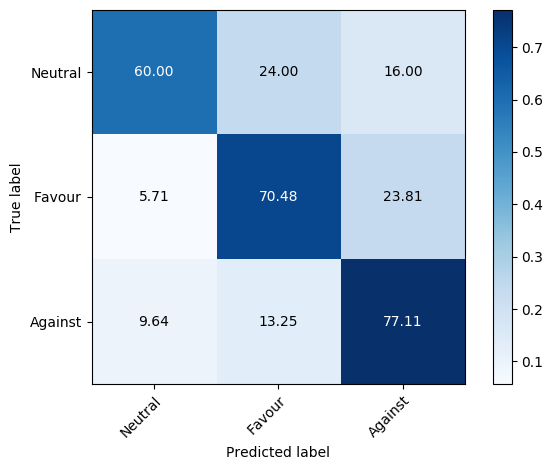

In [243]:
plot_confusion_matrix(testing.stances, predictions.cpu())